# **CVPR** - Assignment 2 
----------------------------------
----------------------------------
# Bojana Počuča and Marco Nobile

## Imports
----------------------------------

In [1]:
import cv2
import matplotlib.path as path
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering
import timeit
import time

Timeit: function to check running time

In [2]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

## Reading and visualising the images for the second image
----------------------------------

In [3]:
img1 = cv2.imread('template2.png') # shape (159, 197, 3)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('target2.png') # shape (591, 1000, 3)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

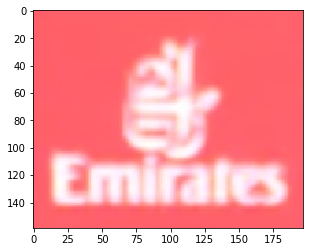

In [19]:
# Template
plt.imshow(img1);

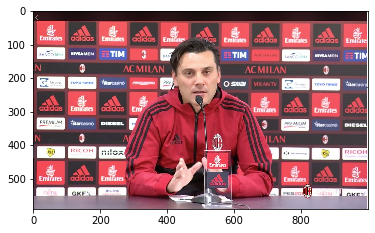

In [20]:
# Target
plt.imshow(img2);

## Feature detection with **SIFT** (Scale-Invariant Feature Transform) 
----------------------------------
After doing feature detection with SURF for the first image, we realized that it was not able to detect some of the keypoints (in this case, it didn't detect the keypoints of the logos on the furthest right of the image), so for this image, we decided to go with SIFT instead.

In [21]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None) # keypoints and relative descriptors for the template
kp2, des2 = sift.detectAndCompute(img2,None) # keypoints and relative descriptors for the target

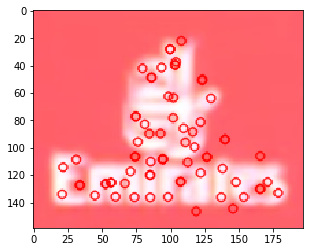

In [22]:
# VISUALIZATION OF KEYPOINTS ON THE TEMPLATE IMAGE
img1_kp1 = cv2.drawKeypoints(img1,kp1,None,(255,0,0),2)
plt.imshow(img1_kp1),plt.show();

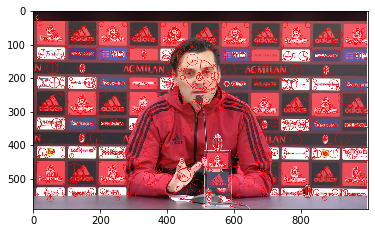

In [23]:
# VISUALIZATION OF KEYPOINTS ON THE TARGET IMAGE
img2_kp2 = cv2.drawKeypoints(img2,kp2,None,(255,0,0),4)
plt.imshow(img2_kp2),plt.show();

In [9]:
# CASTING KEYPOINTS TO: np.arrays such that we can work with them more easly, we build them as 
# shape = (Number_of_kp, 2) i.e. : x,y coords

kp_target = np.empty_like([kp2[0].pt]) # for target
kp_template = np.empty_like([kp1[0].pt]) # for template

for i in range(len(kp2)):
    kp_target = np.append(kp_target, [kp2[i].pt], axis=0)
kp_target = kp_target[1:]
print("Shape of the target image is {}".format(kp_target.shape))

for i in range(len(kp1)):
    kp_template = np.append(kp_template, [kp1[i].pt], axis=0)
kp_template = kp_template[1:]
print("Shape of the template image is {}".format(kp_template.shape))

Shape of the target image is (4090, 2)
Shape of the template image is (70, 2)


## Clustering
----------------------------------
In this case along with the MeanShift, we wanted to try different clustering techniques (agglomerative with l1, agglomerative with cosine, kmeans etc.) and we decided to go with **KMeans**. Again we 'filter out' by clustering 3 times, but this time instead of clustering for the keypoints and descriptors, we clustered for:
    1. Target keypoint clustering (Distance clustering) 
    2. Target color clustering
    3. Template color clustering

In [24]:
@timeit
def k_means(feature, k):
    kmeanModel = KMeans(n_clusters=k, n_init=20, algorithm='elkan',random_state=0)
    kmeanModel.fit(feature)
    print(kmeanModel.inertia_)
    return kmeanModel.cluster_centers_, kmeanModel.labels_

In [26]:
idxsTarget = np.int32(np.round(kp_target,0))
idxsTemplate = np.int32(np.round(kp_template,0))
color2 = img2[idxsTarget[:,1], idxsTarget[:,0], :] # now it's inverted, y then x
color1 = img1[idxsTemplate[:,1], idxsTemplate[:,0], :] # again, (y,x)

The choice of k for the first cluster is simply the ratio of number of target keypoints  with number of template keypoints + a small integer number, because it's better to have a 'greater then needed' number of clusters then a smaller one. <br>
The choice of k for the other two clusters are chosen by studying the image colors and picking the most optimal one.

In [27]:
# Keypoint distance clusters in target image
_, dist_clusters = k_means(kp_target, k=int(np.ceil(len(kp2)/len(kp1)))+5)
# Color clusters in target image
col_centers, col_clusters = k_means(des2, k=4) 
# Color clusters in template image
col_t_centers, col_t_clusters = k_means(des1, k=4) 

3368794.360563268
'k_means'  887.00 ms
507021935.5027198
'k_means'  1137.07 ms
7733296.6485571135
'k_means'  53.50 ms


In [28]:
clust_labels, counts = np.unique(dist_clusters, return_counts=True)
# print (np.asarray((clust_labels, counts)).T)

In [29]:
t_clust_labels, counts = np.unique(col_t_clusters, return_counts=True)
# print (np.asarray((t_clust_labels, counts)).T)

## Visualization of the clustering
----------------------------------

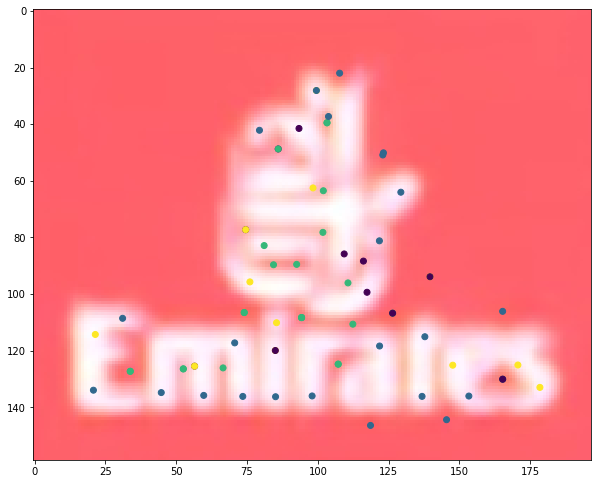

In [31]:
# first in the template
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img1)
ax.scatter(kp_template[:,0],kp_template[:,1], c=col_t_clusters);

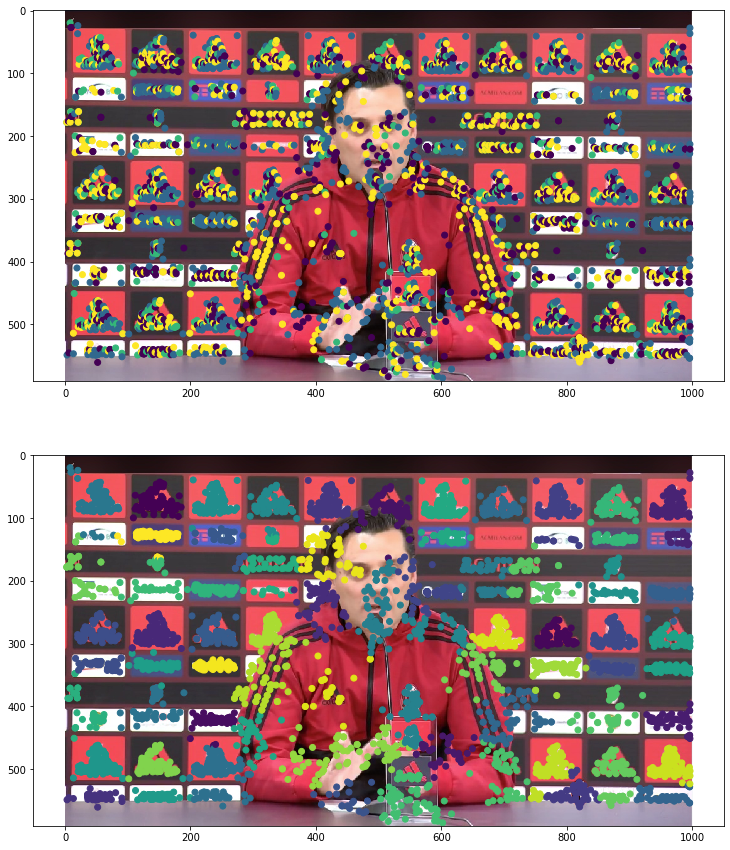

In [32]:
# then in the target
fig, ax = plt.subplots(2,1,figsize=(15,15))
ax[0].imshow(img2)
ax[0].scatter(kp_target[:,0],kp_target[:,1], c=col_clusters);
ax[1].imshow(img2)
discard_outliers = (dist_clusters == -1)
ax[1].scatter(kp_target[~discard_outliers,0],kp_target[~discard_outliers,1], c=dist_clusters[~discard_outliers]);

In [33]:
import scipy.stats as sps
kp1 = np.array(kp1)
kp2 = np.array(kp2)

## Feature (Descriptor) matching with __FLANN__ (Fast Library for Approximate Nearest Neighbors) and multi model fitting with __Sequential RANSAC__.
----------------------------------

The idea is the same as for the first image. The main iterating loop is the same as before, but now for each of those clusters, we go trough all the 'template color clusters' and find a *closest*, most optimal 'target color cluster' so that we can 'mask out' corresponding descriptors (having in mind the colors) along with the keypoints.

## Discarding the bad homographies
In this case, the problem along the finding the right homographies was to find all of the many logos from the target image. Implementing this second set of pictures in the first solution, the program didn't manage to find all 15 template logos on the target image, thus we decided to add some more constraints. <br>
As before, we did the _keypoint and descriptors filtering_, as well as the _ratio test_ (in this case, the number we are multiplying with is smaller since in the target image, the keypoints will be closer to eachoter). Furthermore, the previously implemented constraints for the homographies were kept here as well. <br>
As an additional restraint,  we decided to keep _only_ those homographies whose determinant is between the _average determinant_ (the average determinant of all previously accepted matches) +/- _4 x standard deviation_. This way we make sure to discard very 'far away' homographies.
<br>
The results we got for both the images are perfect. We can see that even the 'part' of the fourth pasta package (on the furthest right) of the target image 1 was matched, which was not the case in the first solution.


Plotting rectagle with det(M):  0.1723476313619749
Plotting rectagle with det(M):  0.1605492904435043
Plotting rectagle with det(M):  0.15226380511204235
Plotting rectagle with det(M):  0.16125656356589677
Plotting rectagle with det(M):  0.1606231942090254
Plotting rectagle with det(M):  0.1571399382255278
Plotting rectagle with det(M):  0.16897034158861443
Plotting rectagle with det(M):  0.15513931081073426
Plotting rectagle with det(M):  0.148901473023501
Plotting rectagle with det(M):  0.15402547956066281
Plotting rectagle with det(M):  0.15016372362158792
Plotting rectagle with det(M):  0.1635834137523262
Plotting rectagle with det(M):  0.16001945870714085
Plotting rectagle with det(M):  0.14711583784910712


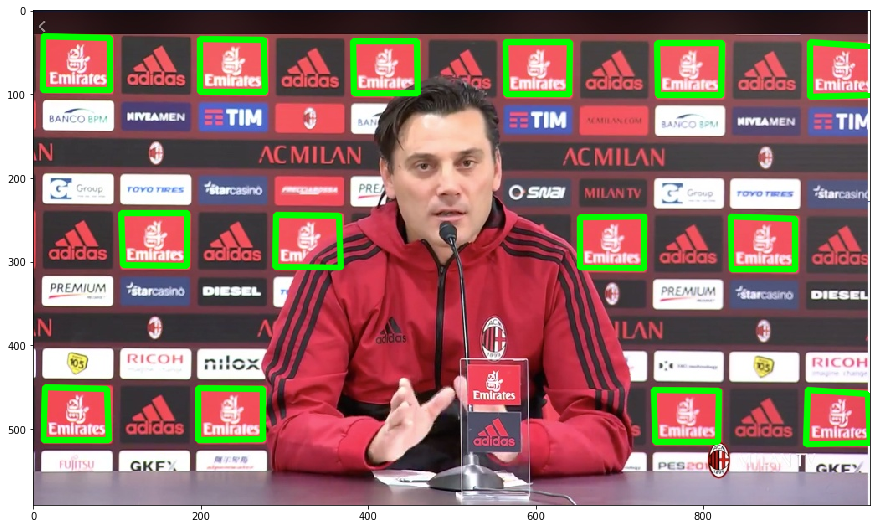

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
img2_k = np.copy(img2)
det = []
homographies = []
for i in clust_labels:
    # Disregarding the 'outlier' cluster (keypoints that didn't fit to any of the clusters)
    # We have obtained the same results even if we didn't disregard this cluster
    if i != -1:
        # Target keypoint mask
        mask_pts_ = np.array(i==dist_clusters)
        kpts_ = kp_target[mask_pts_]
        
        src_pts=[]
        dst_pts=[]
        
        for color in t_clust_labels:
            center = col_t_centers[color,:]
            distance = np.linalg.norm(col_centers-center,1,axis=1)
            corr_clust = np.argmin(distance)
            
            # Target descriptor mask
            mask_col_ = np.array(corr_clust==col_clusters)
            # Template descriptor mask
            mask_t_col_ = np.array(color==col_t_clusters)
            # Merging the masks for the target image (filtering based on both keypoints and descriptors)
            main_mask = (mask_pts_ & mask_col_)

            # FLANN
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
            search_params = dict(checks = 50)
            flann = cv2.FlannBasedMatcher(index_params, search_params)

            # Filtering out the descriptors based on masks
            filtered_des1 = des1[mask_t_col_,:] #template
            filtered_des2 = des2[main_mask,:] #target

            # Filtering out the keypoints based on masks
            filtered_kp1 = kp1[mask_t_col_] #template
            filtered_kp2 = kp2[main_mask] #target

            # Descriptor matching with FLANN & RATIO TEST
            try:
                matches = flann.knnMatch(filtered_des1, filtered_des2, 2)
                for m,n in matches: 
                    if m.distance < 0.6*n.distance:
                        src_pts.append(filtered_kp1[m.queryIdx].pt)
                        dst_pts.append(filtered_kp2[m.trainIdx].pt)
            except:
                pass

        src_pts = np.array(src_pts)
        dst_pts = np.array(dst_pts)

        # RANSAC
        if len(src_pts) > 6:
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2)
             # Discarding Homography (M) with very small determinant (very close to 0) 
            if M is None or (np.linalg.det(M) < 1E-2):
                print(f"Could not find homography for cluster {i}")
            else:
                homographies.append(M)
                det.append(np.linalg.det(M))
#                 print(f"Det found: {np.linalg.det(M)}")

# New constraint

avg_det = np.mean(det)
stdev_det = 4*np.std(det)

for i in range(len(homographies)):
    if (det[i] > (avg_det - stdev_det)) and (det[i] < (avg_det + stdev_det)) and det[i] > 0:
        M = homographies[i]
        print('Plotting rectagle with det(M): ', det[i])
    
        # Plotting
        color = (0, 255, 0) 
        h,w = img1.shape[0], img1.shape[1]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img2_k = cv2.polylines(np.copy(img2_k),[np.int32(dst)],True,color,5, cv2.LINE_AA)

ax.imshow(img2_k);